In [1]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from termcolor import colored

# Preparación de los datos
#### Descripción de las caracteristicas ('features')
- ts:     Hora de inicio del flujo
- te:     Hora de finalización del flujo
- td:     Duración del flujo
- sa:     Dirección IP origen
- da:     Dirección IP de destino
- sp:     Puerto de origen
- dp:     Puerto de destino
- pr:     Protocolo
- flg:    Banderas
- fwd:    Estado de reenvío
- stos:   Tipo de servicio de origen
- ipkt:   Paquetes de entrada
- ibyt:   Bytes de entrada
- opkt:   Paquetes de salida
- obyt:   Bytes de salida
- in:     Interfaz de entrada
- out:    Interfaz de salida
- sas:    Número de sistema autónomo BGP de origen
- das:    Número de sistema autónomo BGP de destino
- smk:    Máscara de red de origen
- dmk:    Máscara de red de destino
- dtos:   Tipo de servicio de destino
- dir:    Dirección del flujo
- nh:     Enrutador de siguiente salto
- nhb:    Enrutador de siguiente salto BGP
- svln:   VLAN de origen
- dvln:   VLAN de destino
- ismc:   Dirección MAC de la fuente de entrada   
- odmc:   Dirección MAC de destino de salida
- idmc:   Introduzca la dirección MAC de destino
- osmc:   Dirección MAC de la fuente de salida
- mpls1:  Etiqueta MPLS 1
- mpls2:  Etiqueta MPLS 2
- mpls3:  Etiqueta MPLS 3
- mpls4:  Etiqueta MPLS 4
- mpls5:  Etiqueta MPLS 5
- mpls6:  Etiqueta MPLS 6
- mpls7:  Etiqueta MPLS 7
- mpls8:  Etiqueta MPLS 8
- mpls9:  Etiqueta MPLS 9
- mpls10: Etiqueta MPLS 10
- cl:     Latencia del cliente
- sl:     Latencia del servidor
- al:     Latencia de la aplicación
- ra:     Exportando la dirección IP del sistema (enrutador)
- eng:    Tipo / ID de motor
- exid:   Exportando el ID del sistema
- tr:     Marca de tiempo de flujo recibido
- type:   Tipo de registro Mina/ no Mina 
- cryptocurrency: : Tipo criptomoneda
- id_Cryptocurrency:: Id Criptomoneda

In [7]:
# Importamos el conjunto de datos
data = pd.read_csv('./DataA_Tratada.csv')
data.head()

,index,References,ts,te,td,sa,da,sp,dp,pr,...,mpls10,cl,sl,al,ra,eng,exid,tr,cryptocurrency,type
0,77204,264-csves/0.csv,2020-09-11 18:07:45,2020-09-11 18:10:46,180.728,192.168.0.13,159.127.41.204,57160,443,TCP,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,Does_not_have,not_mine
1,260246,759-csves/1.csv,2020-09-16 21:57:42,2020-09-16 21:57:42,0.000,192.168.0.13,192.168.0.1,42055,53,UDP,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,Does_not_have,not_mine
2,8053,65-csves/3.csv,2019-04-07 15:30:30,2019-04-07 15:32:20,110.005,192.168.1.99,172.65.207.106,58780,4444,TCP,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,Etherium,mine
3,2927,9-csves/18.csv,2019-04-05 04:08:00,2019-04-05 04:08:26,26.570,172.65.207.106,192.168.1.99,4444,64790,TCP,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,Etherium,mine
4,138179,434-csves/1.csv,2020-09-13 19:16:30,2020-09-13 19:16:30,0.000,192.168.0.13,192.168.0.1,58998,53,UDP,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,Does_not_have,not_mine


### Estructuración del conjunto de datos
Agrupo las columnas de tipo int64, float64 y object por separado, para hacer una analisis mas organizado

In [8]:
data_numeric_int = (data.dtypes == "int64")
data_numeric_float = (data.dtypes == "float64")
data_object  = (data.dtypes == "object")
data_numeric_int = [c for c in data_numeric_int.index if data_numeric_int[c]]
data_numeric_float = [c for c in data_numeric_float.index if data_numeric_float[c]]
data_object = [c for c in data_object.index if data_object[c]]

# Análisis datos 

### Variables Discretas

In [15]:
X = pd.concat([data['sp'],data['dp'],data['ipkt'],data['ibyt']], axis=1)
y = data['type']
y = y.replace({'not_mine': 0, 'mine': 1})

In [16]:
probit_model = Probit(y,X.astype(float)).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.678987
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                   type   No. Observations:                26064
Model:                         Probit   Df Residuals:                    26060
Method:                           MLE   Df Model:                            3
Date:                Wed, 07 Oct 2020   Pseudo R-squ.:                 0.02043
Time:                        19:24:26   Log-Likelihood:                -17697.
converged:                       True   LL-Null:                       -18066.
Covariance Type:            nonrobust   LLR p-value:                1.120e-159
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sp          2.784e-06   2.16e-07     12.912      0.000    2.36e-06    3.21e-06
dp          3.784e-06    2.2e

### Variables Categoricas

In [17]:
def accounts(name_x, name_y,tuples):
    acounts = []
    for i in range(len(tuples)):
        acounts.append(data[(data[name_x] == tuples[i][0]) & (data[name_y] == tuples[i][1])].shape[0])
    
    return acounts

In [22]:
def table_contingency(timon):
    temp_value = []
    for i in timon.index.levels[0]:
        temp_value.append(timon[i][0])
        temp_value.append(timon[i][1])
    temp_value = np.array(temp_value).reshape(2,len(timon.index.levels[0].values),order='F')
    temp_value = pd.DataFrame(temp_value, index = timon.index.levels[1].values[::-1], columns = timon.index.levels[0].values)
    return temp_value

In [46]:
def mosaic_plot(timon, titulo):
    plt.figure(figsize=(20,20))
    ax = plt.subplot()
    ax = mosaic(timon, title=titulo, ax=ax)
    plt.show()

In [20]:
def parametros(c_x,c_y):
    temp_x = list(data[c_x].unique())
    temp_x = pd.Series(temp_x).dropna()
    temp_x = list(temp_x)
    temp_y = list(data[c_y].unique())
    tuples = list(product(temp_x, temp_y))
    acoun = accounts(c_x, c_y,tuples)
    index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
    return acoun, tuples, index

Tabla de contingencia
          ICMP  ICMP6    TCP   UDP
not_mine     5      9   9635  3383
mine         0      0  13032     0


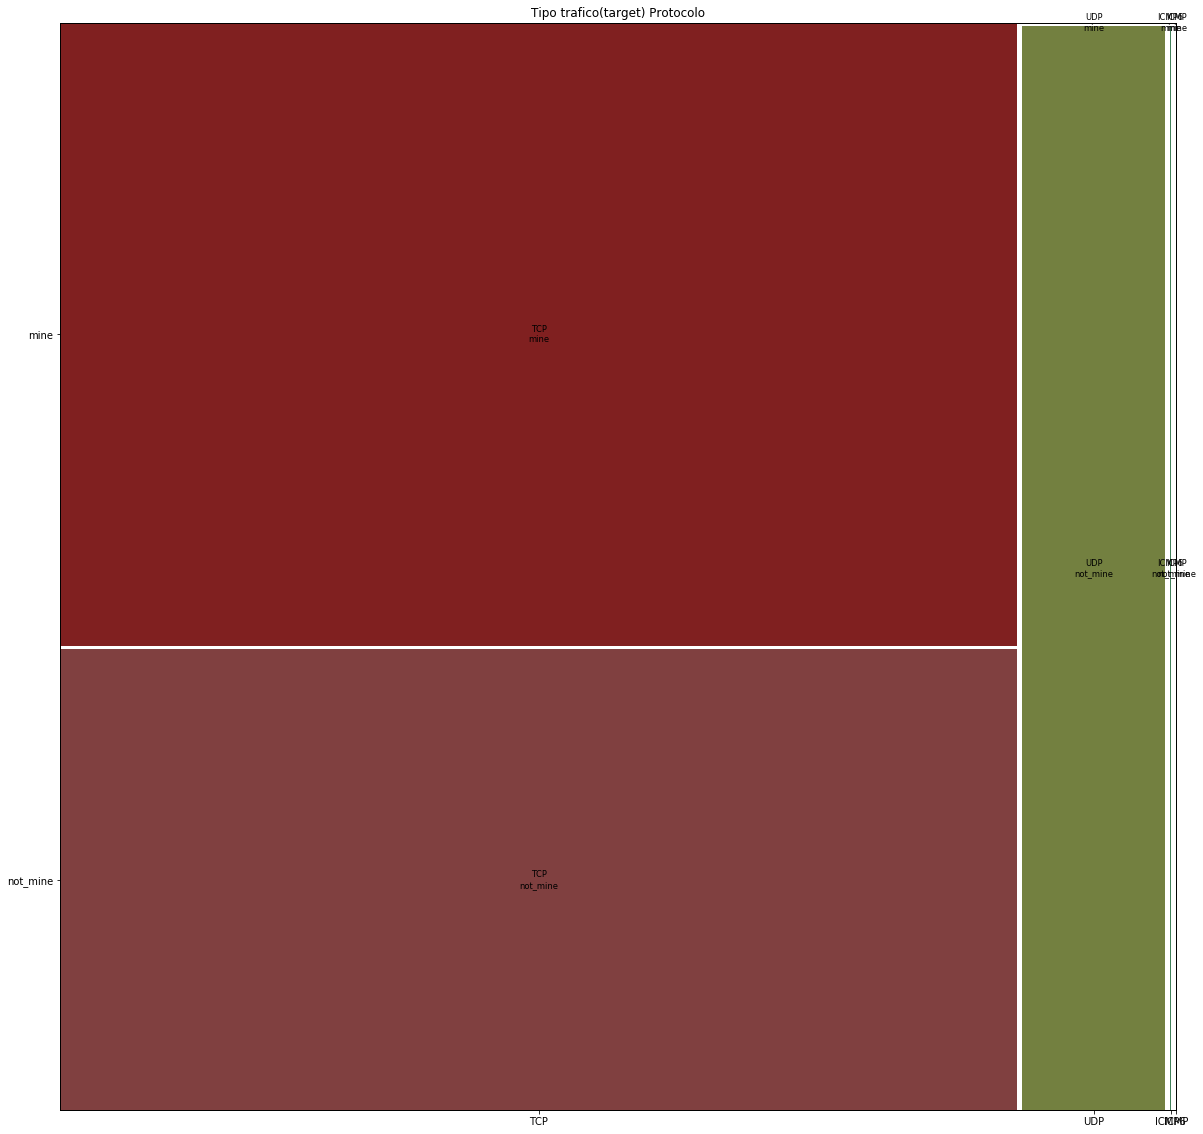

In [51]:
acoun, tuples, index = parametros('pr','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

Tabla de contingencia
          Bitcash  Bitcoin  Does_not_have  Etherium  Litecoin  Monero
not_mine        0        0          13032         0         0       0
mine          987      761              0     10145       745     394


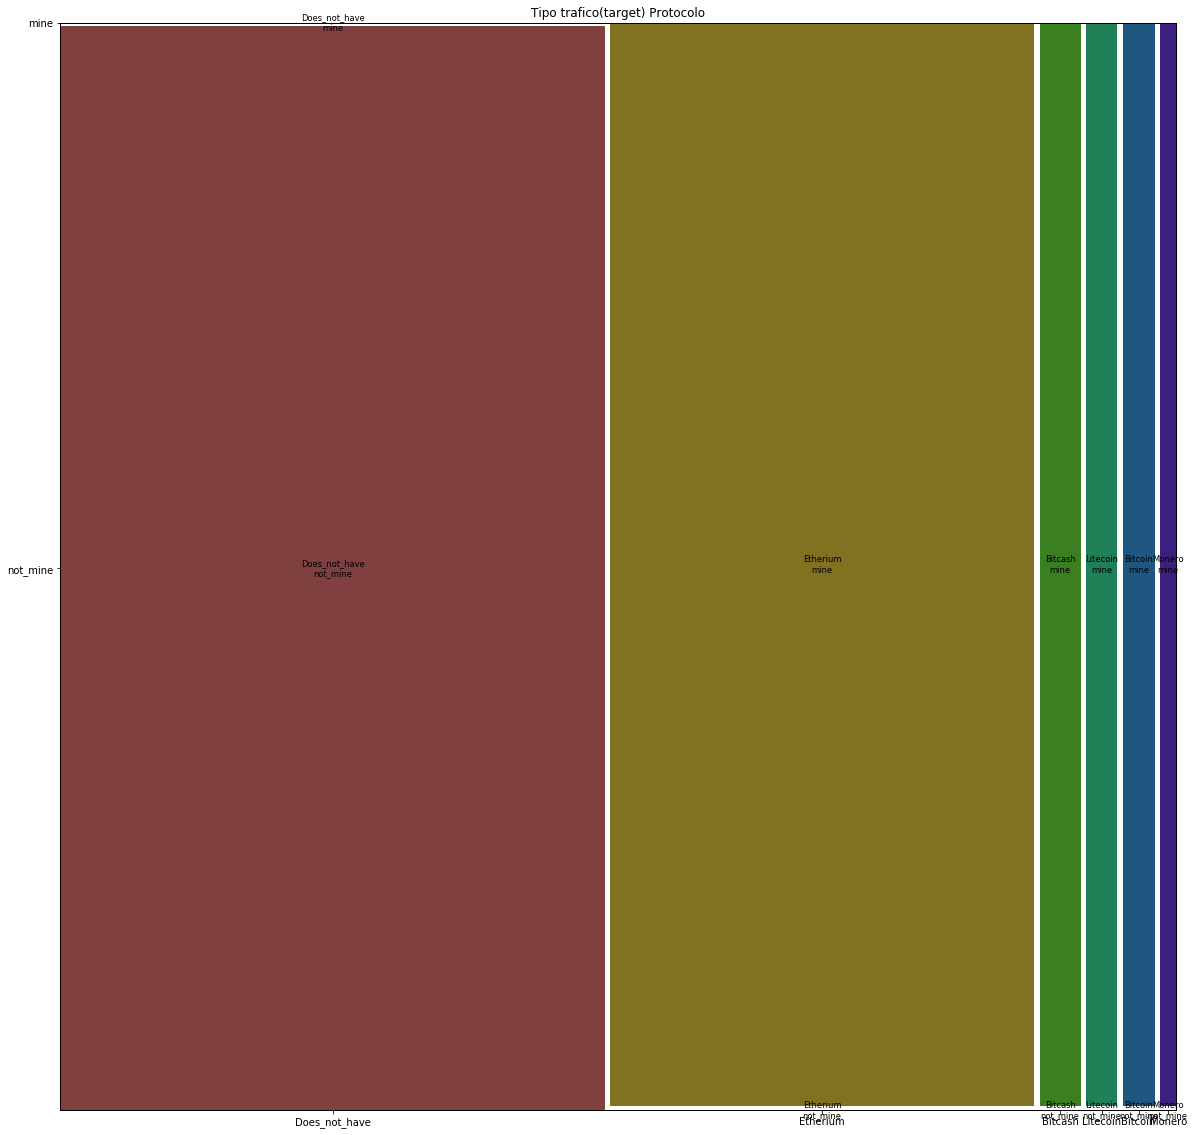

In [48]:
acoun, tuples, index = parametros('cryptocurrency','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

Tabla de contingencia
          ........  ......S.  .....R..  .....RS.  ...A....  ...A...F  \
not_mine      3397        14        72         2      3756       869   
mine             0         1         0         0      1011        58   

          ...A..S.  ...A..SF  ...A.R..  ...A.R.F  ...AP...  ...AP..F  \
not_mine        15         6       151       243       467      1010   
mine             8         7         0         0     11250        63   

          ...AP.S.  ...AP.SF  ...APR..  ...APR.F  ...APRS.  ...APRSF  
not_mine      1368      1088        27        37       284       226  
mine           134       496         2         0         2         0  


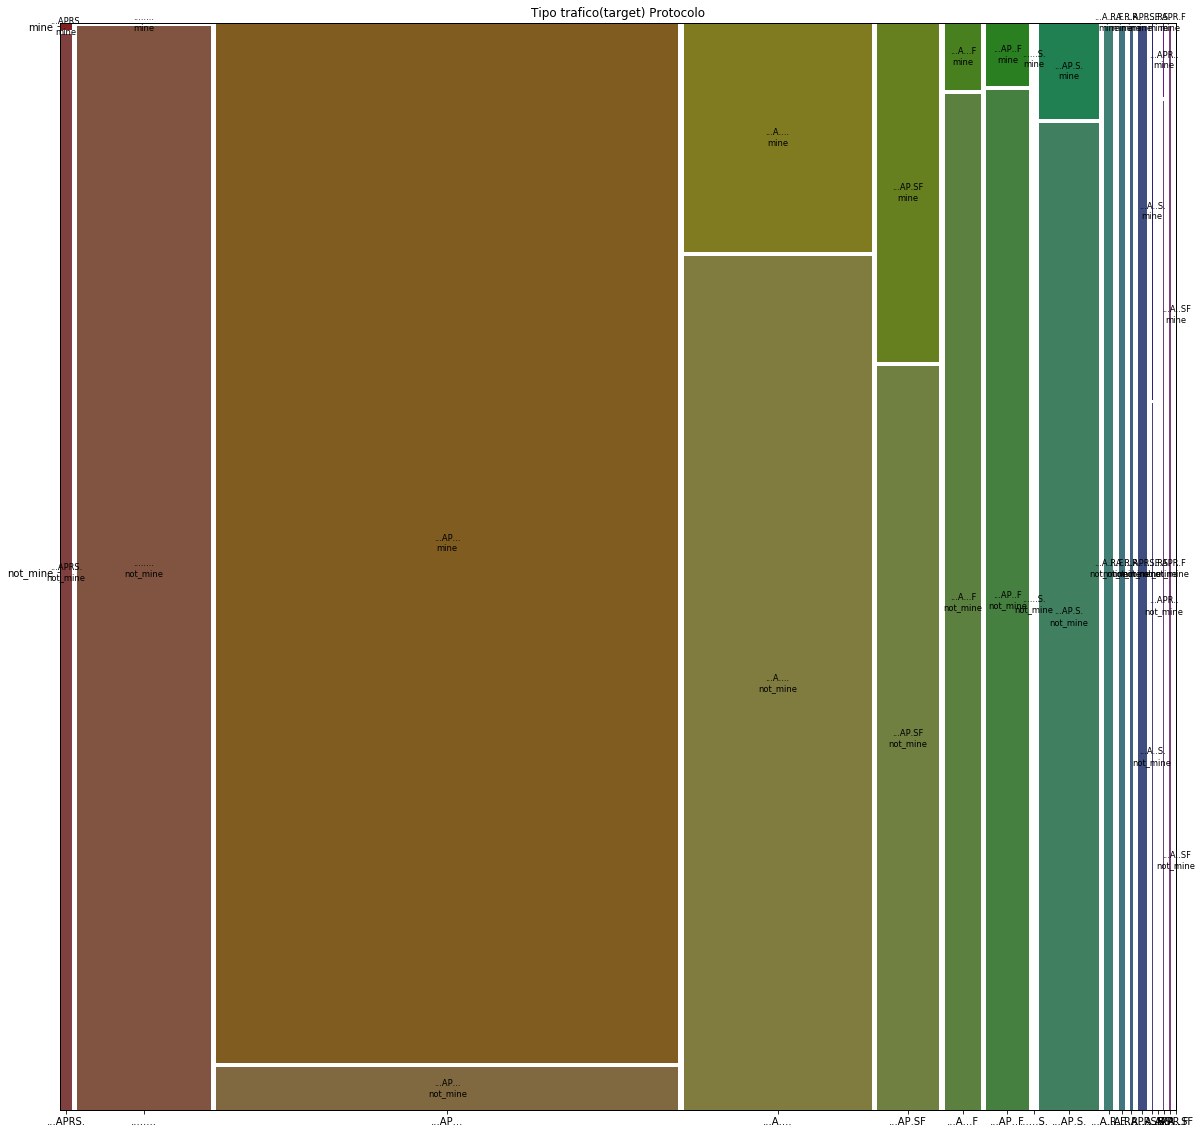

In [49]:
acoun, tuples, index = parametros('flg','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

Tabla de contingencia
          0.0.0.0
not_mine    13032
mine        13032


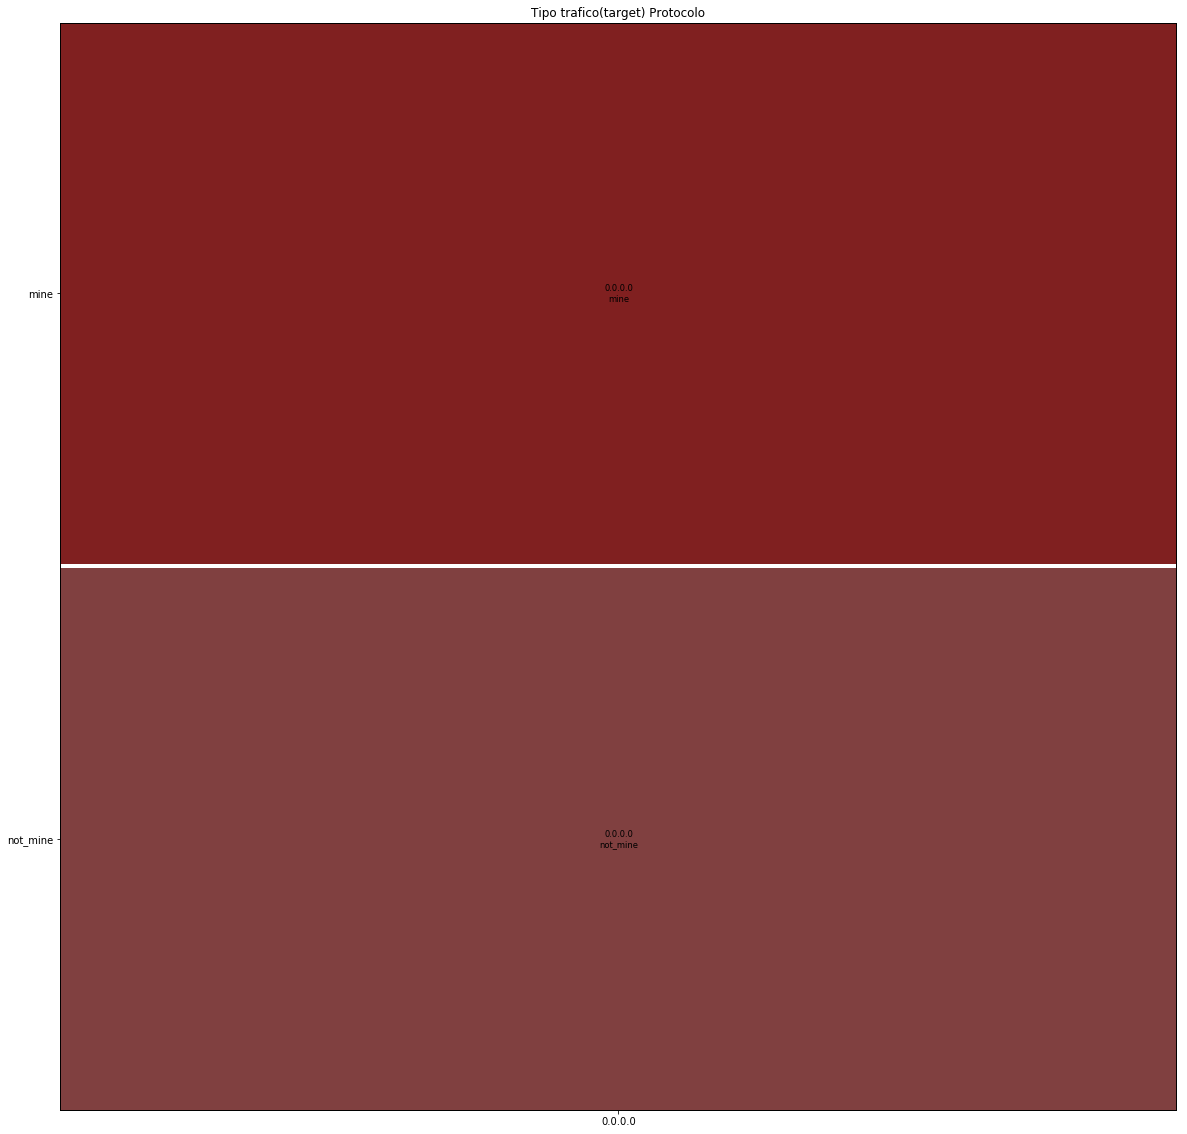

In [50]:
acoun, tuples, index = parametros('nh','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")